<a href="https://colab.research.google.com/github/venkatalakshmi03/CMPE256/blob/main/CNN_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# /content/drive/MyDrive/Reviews.csv.zip

In [1]:
!unzip /content/drive/MyDrive/Reviews.csv.zip

Archive:  /content/drive/MyDrive/Reviews.csv.zip
  inflating: Reviews.csv             


In [2]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix,f1_score,precision_score,recall_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from bs4 import BeautifulSoup
import re,string,unicodedata



In [3]:
data_path = "/content/Reviews.csv"

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
np.unique(df.Score,return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 52268,  29769,  42640,  80655, 363122]))

In [7]:
print("Negative review count:",sum(df.Score <=2))
print("Positive review count:",sum(df.Score >3))

Negative review count: 82037
Positive review count: 443777


In [8]:
df.loc[df['Score'] <=2, 'Sentiment'] = int(0)
df.loc[df['Score'] > 3, 'Sentiment'] = int(1)

In [9]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0


In [10]:
df.drop(df[df['Score']==3].index,inplace=True)

In [11]:
df.shape

(525814, 11)

In [12]:
np.unique(df.Score,return_counts=True)

(array([1, 2, 4, 5]), array([ 52268,  29769,  80655, 363122]))

In [13]:
print("Negative review count:",sum(df.Score <=2))
print("Positive review count:",sum(df.Score >3))

Negative review count: 82037
Positive review count: 443777


In [14]:
df_sentiment = df[['Text','Sentiment']]

In [15]:
df_sentiment.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,1.0
3,If you are looking for the secret ingredient i...,0.0
4,Great taffy at a great price. There was a wid...,1.0


In [16]:
np.unique(df_sentiment.Sentiment, return_counts=True)

(array([0., 1.]), array([ 82037, 443777]))

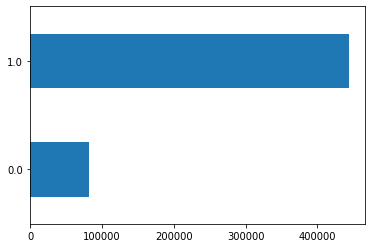

In [17]:
df_sentiment.Sentiment.value_counts().sort_values().plot(kind = 'barh')

In [18]:
df_sentiment.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [19]:


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df_sentiment['Text']=df_sentiment['Text'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [22]:
df_sentiment.Text = df_sentiment.Text.apply(stem_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
df_sentiment.head()

,Text,Sentiment
0,bought sever vital can dog food product found ...,1.0
1,product arriv label jumbo salt peanuts...th pe...,0.0
2,"confect around centuries. light, pillowi citru...",1.0
3,look secret ingredi robitussin believ found it...,0.0
4,great taffi great price. wide assort yummi taf...,1.0


In [24]:
df_sentiment['Text'] = df_sentiment.Text.str.replace('[^a-zA-Z ]', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_sentiment.head()

,Text,Sentiment
0,bought sever vital can dog food product found ...,1.0
1,product arriv label jumbo salt peanutsth peanu...,0.0
2,confect around centuries light pillowi citru g...,1.0
3,look secret ingredi robitussin believ found it...,0.0
4,great taffi great price wide assort yummi taff...,1.0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_sentiment['Text'], df_sentiment['Sentiment'], test_size=0.20, random_state=42)

In [27]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [28]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [30]:
vocab_size

244096

In [31]:
class_weights=class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(df_sentiment['Sentiment']),
    y = np.array(df_sentiment['Sentiment'])
)

In [32]:
class_weights_dict = {0: 3.20473689, 1:0.59243043}

In [33]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          24409600  
                                                                 
 conv1d (Conv1D)             (None, 93, 32)            25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 10)                14730     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [34]:

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10
13146/13146 - 3383s - loss: 0.1798 - accuracy: 0.9314 - 3383s/epoch - 257ms/step
Epoch 2/10
13146/13146 - 3366s - loss: 0.1093 - accuracy: 0.9602 - 3366s/epoch - 256ms/step
Epoch 3/10
13146/13146 - 3388s - loss: 0.0643 - accuracy: 0.9773 - 3388s/epoch - 258ms/step
Epoch 4/10
13146/13146 - 3395s - loss: 0.0356 - accuracy: 0.9877 - 3395s/epoch - 258ms/step
Epoch 5/10
13146/13146 - 3387s - loss: 0.0222 - accuracy: 0.9926 - 3387s/epoch - 258ms/step
Epoch 6/10
13146/13146 - 3448s - loss: 0.0152 - accuracy: 0.9949 - 3448s/epoch - 262ms/step
Epoch 7/10
13146/13146 - 3394s - loss: 0.0111 - accuracy: 0.9962 - 3394s/epoch - 258ms/step
Epoch 8/10
13146/13146 - 3380s - loss: 0.0093 - accuracy: 0.9968 - 3380s/epoch - 257ms/step
Epoch 9/10
13146/13146 - 3365s - loss: 0.0074 - accuracy: 0.9975 - 3365s/epoch - 256ms/step
Epoch 10/10
13146/13146 - 3379s - loss: 0.0064 - accuracy: 0.9978 - 3379s/epoch - 257ms/step


In [35]:
predictions_prob = model.predict(X_test)
predictions = np.array([1 if x > 0.5 else 0 for x in predictions_prob])

In [36]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     16217
           1       0.97      0.97      0.97     88946

    accuracy                           0.94    105163
   macro avg       0.89      0.90      0.89    105163
weighted avg       0.95      0.94      0.94    105163



In [37]:

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions_prob)
auc_keras = auc(fpr_keras, tpr_keras)

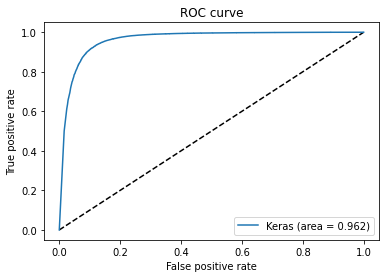

In [38]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [39]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [40]:
model_w = Sequential()
model_w.add(Embedding(vocab_size, 100, input_length=maxlen))
model_w.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model_w.add(MaxPooling1D(pool_size=2))
model_w.add(Flatten())
model_w.add(Dense(10, activation='relu'))
model_w.add(Dense(1, activation='sigmoid'))
print(model_w.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          24409600  
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 32)            25632     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                14730     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

In [ ]:

# compile network
model_w.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
# fit network
model_w.fit(X_train, y_train, epochs=10, verbose=2,class_weight=class_weights_dict)

Epoch 1/10
13146/13146 - 3395s - loss: 0.2730 - f1: 0.9302 - 3395s/epoch - 258ms/step
Epoch 2/10
13146/13146 - 3379s - loss: 0.1757 - f1: 0.9573 - 3379s/epoch - 257ms/step
Epoch 3/10
13146/13146 - 3378s - loss: 0.1187 - f1: 0.9721 - 3378s/epoch - 257ms/step
Epoch 4/10
13146/13146 - 3388s - loss: 0.0792 - f1: 0.9813 - 3388s/epoch - 258ms/step
Epoch 5/10
13146/13146 - 3439s - loss: 0.0545 - f1: 0.9871 - 3439s/epoch - 262ms/step
Epoch 6/10
13146/13146 - 3472s - loss: 0.0410 - f1: 0.9903 - 3472s/epoch - 264ms/step
Epoch 7/10
13146/13146 - 3426s - loss: 0.0326 - f1: 0.9926 - 3426s/epoch - 261ms/step
Epoch 8/10
13146/13146 - 3406s - loss: 0.0274 - f1: 0.9939 - 3406s/epoch - 259ms/step
Epoch 9/10


In [ ]:
predictions_prob_w = model_w.predict(X_test)
predictions_w = np.array([1 if x > 0.5 else 0 for x in predictions_prob_w])
print(classification_report(predictions_w,y_test))

In [ ]:
fpr_keras_w, tpr_keras_w, thresholds_keras_w = roc_curve(y_test, predictions_prob_w)
auc_keras_w = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_w, tpr_keras_w, label='Keras (area = {:.3f})'.format(auc_keras_w))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()